In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
from matplotlib import font_manager

plt.style.use("seaborn-v0_8-darkgrid")
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\osh612\miniconda3\envs\osh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def mape(y_pred, y_true):
    return (np.abs(y_pred - y_true) / y_true).mean() * 100


def mae(y_pred, y_true):
    return np.abs(y_pred - y_true).mean()


def mse(y_pred, y_true):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)


def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))


def r_squered(y_pred, y_true):
    return r2_score(y_true, y_pred)


def r2_score(y_pred, y_true):
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [3]:
class StatefulLSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.reset_state()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.head = nn.Linear(hidden_size, output_size)

    def reset_state(self, state=None):
        self.state = state

    def forward(self, x):
        assert x.dim() == 2  # (sequence_length, input_size)

        if self.state is None:
            x, (hn, cn) = self.rnn(x)  # state will be set to be zeros by default
        else:
            x, (hn, cn) = self.rnn(x, self.state)  # pass the saved state

        # Check the shape of x here
        # print("Shape of x after LSTM:", x.shape)
        # x.shape == (sequence_length, hidden_size)
        self.reset_state((hn.detach(), cn.detach()))  # save the state
        x = self.head(x)  # (sequence_length, output_size)
        return F.sigmoid(x)

    def predict(self, x0, steps, state=None):
        if state is not None:
            self.reset_state(state)

        output = []
        x = x0.reshape(1, -1)
        for i in range(steps):
            x = self.forward(x)
            output.append(x)
        return torch.concat(output, 0)

In [4]:
class StatefulLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.reset_state()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.head = nn.Linear(hidden_size, output_size)

    def reset_state(self, state=None):
        self.state = state

    def forward(self, x):
        assert x.dim() == 2  # (sequence_length, input_size)

        if self.state is None:
            x, (hn, cn) = self.rnn(x)  # state will be set to be zeros by default
        else:
            x, (hn, cn) = self.rnn(x, self.state)  # pass the saved state

        # Check the shape of x here
        # print("Shape of x after LSTM:", x.shape)
        # x.shape == (sequence_length, hidden_size)
        self.reset_state((hn.detach(), cn.detach()))  # save the state
        x = self.head(x)  # (sequence_length, output_size)
        return F.sigmoid(x)

    def predict(self, x0, steps, state=None):
        if state is not None:
            self.reset_state(state)

        output = []
        x = x0.reshape(1, -1)
        for i in range(steps):
            x = self.forward(x)
            output.append(x)
        return torch.concat(output, 0)

In [5]:
class StatelessLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)  # state will be set to be zeros by default
        # x.shape == (batch_size, sequence_length, hidden_size)
        x = self.head(x)  # (batch_size, sequence_length, output_size)
        return F.sigmoid(x)

    def predict(self, x, steps, state=None):
        output = []
        for i in range(steps):
            x = self.forward(x)
            output.append(x[-1:])
        return torch.concat(output, 0)

In [6]:
results = []
dataLabel = "2002-2021-05_all"

fig_directory = "fig"
csv_directory = "csv"
model_directory = "model"

# 폴더 경로 리스트
folders = [fig_directory, csv_directory, model_directory]

# 각 폴더가 존재하지 않으면 생성
for folder in folders:
    os.makedirs(folder , exist_ok=True)

In [7]:
# 하이퍼파라미터 정의
input_size, hidden_size, output_size, layers, period = 2, 2, 2, 2, 15
# 히든size 512, 1024 , layer 최대 4개까지 , output 1개보고 1개 예측부터,
# 트레인도 같이보면 잘 나오는지 예측을 잘 하다가 뒤에가서 직선이 나오는건지 확인이 가능하다.
# 앞에서부터 직선형태가 나오는지, state리셋하고 관찰해보면 모델이 예측을 잘하는 능력이 없는건지
# 트레인은 잘 예측하고 테스트는 예측을 잘못하는지 분석가능,

In [8]:
# 설정값을 저장할 기본 디렉토리
base_directory = "config_files"

dates = ["15일", "30일", "60일", "90일"]

list15 = [
    # [2, 2, 2, 3, 15],
    # [2, 4, 2, 3, 15],
    [2, 16, 2, 3, 15],
    # [2, 32, 2, 3, 15],
    # [2, 64, 2, 3, 15],
    # [2, 128, 2, 3, 15],
    # [2, 256, 2, 3, 15],
    # [2, 512, 2, 3, 15],
    # [2, 1024, 2, 3, 15],
]
list30 = [
    # [2, 2, 2, 3, 30],
    # [2, 4, 2, 3, 30],
    # [2, 16, 2, 3, 30],
    # [2, 32, 2, 3, 30],
    # [2, 64, 2, 3, 30],
    # [2, 128, 2, 3, 30],
    # [2, 256, 2, 3, 30],
    # [2, 512, 2, 3, 30],
    # [2, 1024, 2, 3, 30],
]
list60 = [
    # [2, 2, 2, 3, 60],
    # [2, 4, 2, 3, 60],
    # [2, 16, 2, 3, 60],
    # [2, 32, 2, 3, 60],
    # [2, 64, 2, 3, 60],
    # [2, 128, 2, 3, 60],
    # [2, 256, 2, 3, 60],
    # [2, 512, 2, 3, 60],
    # [2, 1024, 2, 3, 60],
]
list90 = [
    # [2, 2, 2, 3, 90],
    # [2, 4, 2, 3, 90],
    # [2, 16, 2, 3, 90],
    # [2, 32, 2, 3, 90],
    # [2, 64, 2, 3, 90],
    # [2, 128, 2, 3, 90],
    # [2, 256, 2, 3, 90],
    # [2, 512, 2, 3, 90],
    # [2, 1024, 2, 3, 90],
]

# 각 날짜별로 설정값 리스트
config_lists = {
    "15일": list15,  # list_2021_05는 해당 날짜에 해당하는 설정 리스트
    "30일": list30,  # 각 리스트를 정의해야 함
    "60일": list60,  # 각 리스트를 정의해야 함
    "90일": list90,  # 각 리스트를 정의해야 함
    # 다른 날짜에 대한 리스트도 이와 같이 추가
}

# 각 날짜별 폴더를 만들고 설정값을 config.json 파일로 저장
for date, configs in config_lists.items():
    # 날짜별 폴더 생성
    folder_path = os.path.join(base_directory, date)
    os.makedirs(folder_path, exist_ok=True)

    # 각 설정값을 JSON 파일로 저장
    for i, config in enumerate(configs):
        config_dict = {
            "input_size": config[0],
            "hidden_size": config[1],
            "output_size": config[2],
            "layers": config[3],
            "period": config[4],
        }
        file_path = os.path.join(folder_path, f"config_{i}.json")
        with open(file_path, "w") as file:
            json.dump(config_dict, file, indent=4)

100%|██████████| 2000/2000 [05:24<00:00,  6.16it/s, trn_loss=2.2e-6, tst_loss=0.000275] 


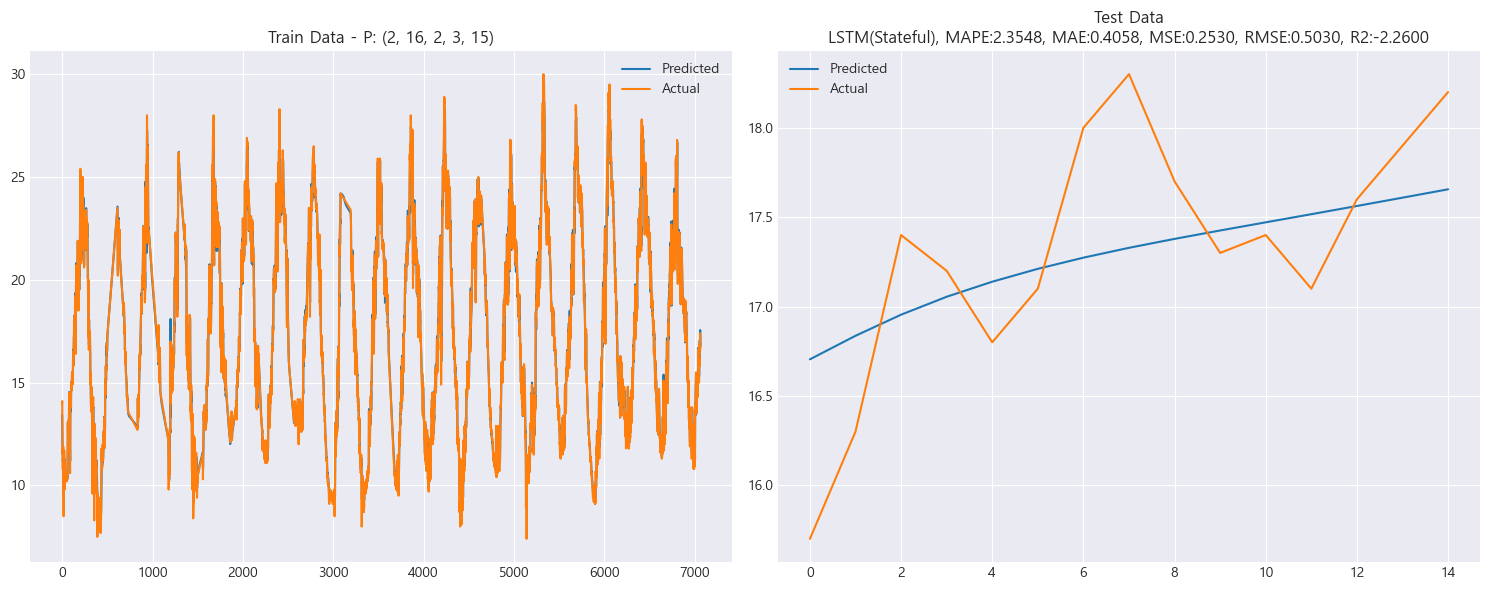

In [9]:
selected_list = list15

for input_size, hidden_size, output_size, layers, period in selected_list:
    # 데이터 스케일링 및 준비
    df = pd.read_csv(f"../Data/{dataLabel}.csv")
    df.head()
    df["일시"] = df["Unnamed: 0"]
    df = df.drop(columns="Unnamed: 0")
    df["일시"] = pd.to_datetime(df["일시"])
    df.set_index("일시", inplace=True)

    data = df
    prd_size = period
    tst_size = prd_size

    data_mw = data.copy()
    data_mw["rolling_avg"] = data["평균 수온(°C)"].rolling(12).mean()
    data_mw = data_mw.dropna()
    trn, tst = data_mw[:-period], data_mw[-period:]
    scaler = MinMaxScaler()
    scaler_ra = MinMaxScaler()
    trn_scaled, tst_scaled = trn.copy(), tst.copy()
    trn_scaled["평균 수온(°C)"] = scaler.fit_transform(
        trn["평균 수온(°C)"].to_numpy(np.float32).reshape(-1, 1)
    )
    trn_scaled["rolling_avg"] = scaler_ra.fit_transform(
        trn.rolling_avg.to_numpy(np.float32).reshape(-1, 1)
    )
    tst_scaled["평균 수온(°C)"] = scaler.transform(
        tst["평균 수온(°C)"].to_numpy(np.float32).reshape(-1, 1)
    )
    tst_scaled["rolling_avg"] = scaler_ra.transform(
        tst.rolling_avg.to_numpy(np.float32).reshape(-1, 1)
    )
    # print(tst_scaled.shape,trn_scaled.shape)
    trn_scaled = trn_scaled.to_numpy(np.float32)
    tst_scaled = tst_scaled.to_numpy(np.float32)

    # 한글 글꼴 설정
    # 사용 가능한 글꼴 리스트를 가져옵니다
    available_fonts = set(f.name for f in font_manager.fontManager.ttflist)
    if "NanumGothic" in available_fonts:
        plt.rcParams["font.family"] = "NanumGothic"
    else:
        plt.rcParams["font.family"] = "Malgun Gothic"

    # 모델 정의
    batch_size = 128
    trn_x = torch.tensor(trn_scaled[:-1]).split(batch_size)
    trn_y = torch.tensor(trn_scaled[1:]).split(batch_size)
    tst_y = torch.tensor(tst_scaled)

    # 모델 학습
    rnn = StatefulLSTM2(input_size, hidden_size, output_size, layers)
    rnn.to(device)
    # 히든사이즈, 레이처갯수 증가시켜보기
    # 하이퍼 파라미터 변동 기록
    # 2 16 2 2
    # 2 32 2 3
    # 2 64 2 4

    optim = torch.optim.AdamW(rnn.parameters(), lr=0.0001)

    # 옵티마이저 건드려보자.
    # Adam말고 다른거 lion 예전거들도 성능좋은거 있다.
    # 바꿔보자

    trn_predictions = []
    pbar = trange(2000)
    for e in pbar:
        rnn.train()
        rnn.reset_state()
        trn_loss = 0.0
        for x, y in zip(trn_x, trn_y):
            x, y = x.to(device), y.to(device)
            optim.zero_grad()
            p = rnn(x)
            loss = F.mse_loss(p, y)
            loss.backward()
            optim.step()
            trn_loss += loss.item()
            # 훈련 데이터에 대한 예측값 저장
            if e == len(pbar) - 1:  # 마지막 에폭에서만 저장
                trn_predictions.append(p.detach().cpu().numpy())
        trn_loss /= len(trn) - 1

        rnn.eval()
        with torch.inference_mode():
            p = rnn.predict(y[-1:].to(device), len(tst_y))
            tst_loss = F.mse_loss(p, tst_y.to(device)).item()
        pbar.set_postfix({"trn_loss": trn_loss, "tst_loss": tst_loss})

    # 성능 지표 계산
    prd = scaler.inverse_transform(p.cpu()[:, :1])
    mape_val = mape(prd, tst["평균 수온(°C)"].values.reshape(-1, 1))
    mae_val = mae(prd, tst["평균 수온(°C)"].values.reshape(-1, 1))
    mse_val = mse(prd, tst["평균 수온(°C)"].values.reshape(-1, 1))
    rmse_val = rmse(prd, tst["평균 수온(°C)"].values.reshape(-1, 1))
    r2_val = r_squered(prd, tst["평균 수온(°C)"].values.reshape(-1, 1))

    # 결과 저장
    tmp = (input_size, hidden_size, output_size, layers, period)
    results.append([tmp, mape_val, mae_val, mse_val, rmse_val, r2_val])

    # 모델 저장
    torch.save(rnn.state_dict(), f"./model/{dataLabel}_LSTM-io_22{tmp}.pth")

    trn_predictions = scaler.inverse_transform(
        np.concatenate(trn_predictions, axis=0)[:, :1]
    )

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1행 2열로 두 개의 그래프를 생성

    # 첫 번째 그래프 (학습 데이터)
    # axs[0].plot(np.concatenate(trn_predictions, axis=0)[:, 0].reshape(-1,1), label='Predicted')
    axs[0].plot(trn_predictions, label="Predicted")
    axs[0].plot(trn.iloc[1:, 0].values.reshape(-1, 1), label="Actual")
    axs[0].set_title(f"Train Data - P: {tmp}")
    axs[0].legend()

    # 두 번째 그래프 (테스트 데이터)
    axs[1].plot(prd, label="Predicted")
    axs[1].plot(tst["평균 수온(°C)"].to_numpy(), label="Actual")
    axs[1].set_title(
        f"Test Data\nLSTM(Stateful), MAPE:{mape_val:.4f}, MAE:{mae_val:.4f}, MSE:{mse_val:.4f}, RMSE:{rmse_val:.4f}, R2:{r2_val:.4f}"
    )
    axs[1].legend()
    plt.tight_layout()  # 그래프 간 간격 조정

    plt.savefig(f"./fig/{dataLabel}_LSTM-io_22{tmp}.png")
    plt.show()

In [10]:
# 결과 DataFrame 생성
results_df = pd.DataFrame(
    results, columns=["Parmeter", "MAPE", "MAE", "MSE", "RMSE", "R2"]
)
results_df.to_csv(f"./csv/{dataLabel}_LSTM-io_22{tmp}.csv")
results_df

,Parmeter,MAPE,MAE,MSE,RMSE,R2
0,"(2, 16, 2, 3, 15)",2.354753,0.405805,0.253017,0.503007,-2.26
